<a href="https://colab.research.google.com/github/Ahmed-Camara/Facial-Emotion-Detection-using-deep-learning/blob/main/Human_face_emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization,ZeroPadding2D, Activation
from tensorflow.keras.utils import plot_model 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing import image

In [ ]:
import cv2
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
#files = '/content/drive/MyDrive/DataSets/archive.zip'
dataset_path = '/content/drive/MyDrive/ML_DL_practice/Human Face Emotion Detection/data/archive.zip'
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset/')

In [ ]:
train_path = '/content/dataset/train'
test_path = '/content/dataset/test'

In [ ]:
os.listdir(train_path)

['surprise', 'neutral', 'happy', 'angry', 'fear', 'disgust', 'sad']

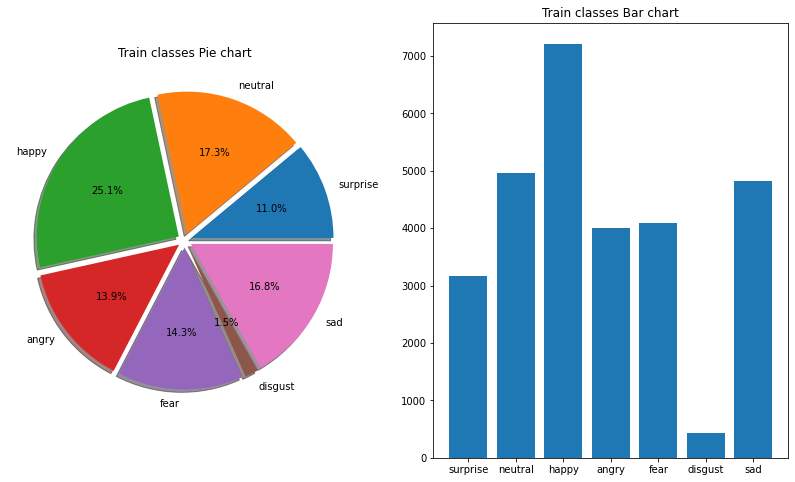

In [ ]:
def get_counts(path):
  emotions = os.listdir(path)

  cls_counts = {}
  for emotion in emotions:
    count = len(os.listdir(os.path.join(path, emotion)))
    
    cls_counts[emotion] = count

  return cls_counts
train_counts = get_counts(train_path)
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (14, 8))

explode = [0.05] * 7


ax0.set_title('Train classes Pie chart')
ax0.pie(train_counts.values(), labels=train_counts.keys(),
       explode=explode, autopct='%1.1f%%', shadow=True)
ax1.set_title('Train classes Bar chart')
ax1.bar(train_counts.keys(), train_counts.values(), width=0.8)


#fig.savefig('/content/pie_fer2013.png')
plt.show()

#### Hyperparameters && parameters

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
epochs = 50
base_learning_rate = 0.001
fine_learning_rate = 1e-4
dropout_factor = 0.5

loss_function=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate)
fine_optimizer = tf.keras.optimizers.RMSprop(learning_rate=fine_learning_rate)
metrics=['accuracy']

#### Load data

In [ ]:
train_dataset = image_dataset_from_directory(train_path,shuffle=True, batch_size=BATCH_SIZE,
                                             image_size=IMAGE_SIZE,validation_split=0.2,subset='training', seed = 42)
validation_dataset = image_dataset_from_directory(train_path,shuffle=True, 
                                                  batch_size=BATCH_SIZE,image_size=IMAGE_SIZE,validation_split=0.2
                                                  ,subset='validation', seed = 42)

test_dataset = image_dataset_from_directory(test_path,shuffle=True, 
                                                  batch_size=BATCH_SIZE,image_size=IMAGE_SIZE
                                                  , seed = 42)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


In [ ]:
class_names = train_dataset.class_names
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

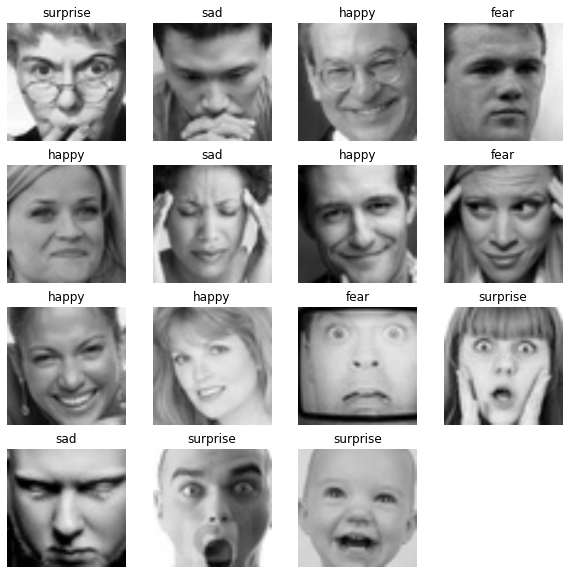

In [ ]:

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(15):
        ax = plt.subplot(4,4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

## Data augmentation

In [ ]:
import tensorflow.keras.layers as tfl
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

def data_augmenter():
  data_augmentation = tf.keras.Sequential()
  data_augmentation.add(RandomFlip('horizontal'))
  data_augmentation.add(RandomRotation(0.2))
  return data_augmentation

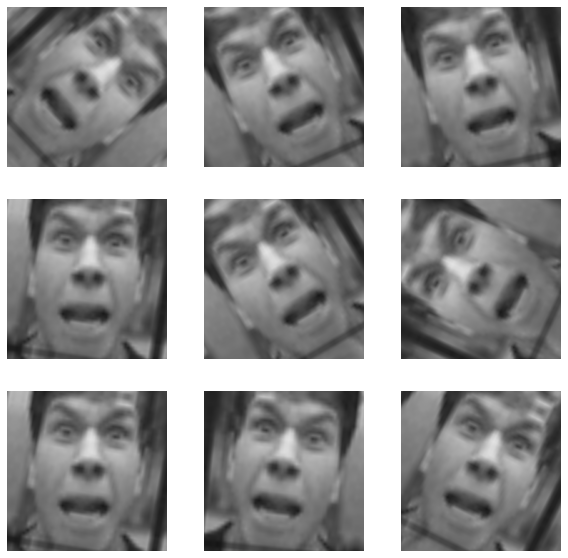

In [ ]:
data_augmentation = data_augmenter()
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In this project, we are using only transfer learning to build our models. First, we will train our model on top of the architecture then we will use fine-tuning model to increase our accuracy.

In [ ]:
def draw_diagram(hist):
  fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (16, 8))


  ax0.plot(hist.history['accuracy'])
  ax0.plot(hist.history['val_accuracy'])
  ax0.set_title('Model Accuracy')
  ax0.set_xlabel('Epochs')
  ax0.set_ylabel('Accuracy')
  ax0.legend(['train', 'test'], loc='upper left')



  ax1.plot(hist.history['loss'])
  ax1.plot(hist.history['val_loss'])
  ax1.set_title('Model Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.legend(['train', 'test'], loc='upper left')

  fig.savefig('/content/fer_resutls.png')
  plt.show()

In [ ]:
IMAGE_SHAPE = IMAGE_SIZE + (3,)

# Transfer Learning

##### Model function

In [ ]:
def build_model(image_shape=IMAGE_SHAPE,data_augmentation=data_augmenter(),mod='dense'):

  input_shape = image_shape + (3,)
  base_model = None
  preprocess_input = None
    
  if mod == 'dense':
    preprocess_input = tf.keras.applications.densenet.preprocess_input
    base_model = tf.keras.applications.DenseNet201(input_shape=input_shape,include_top=False,weights='imagenet')
  
  elif mod == 'efficientnet':
    preprocess_input = tf.keras.applications.efficientnet.preprocess_input
    base_model = tf.keras.applications.EfficientNetB1(input_shape=input_shape,include_top=False,weights='imagenet')
  
  elif mod == 'resnet':
    preprocess_input = tf.keras.applications.resnet50.preprocess_input
    base_model = tf.keras.applications.ResNet101(input_shape=input_shape,include_top=False,weights='imagenet')
  
  base_model.trainable = False 
  inputs = tf.keras.Input(shape=input_shape)
  x = data_augmentation(inputs)
  x = preprocess_input(x)
  x = base_model(x, training=False)
  x = tfl.GlobalAveragePooling2D()(x)
  x = tfl.Dropout(dropout_factor)(x)
  outputs = tfl.Dense(7)(x)
  model = tf.keras.Model(inputs, outputs)
  return base_model,model

##### callback Function

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
callbacks = [stop_early]

#### DenseNet

In [ ]:
base_model, dense_model = build_model(IMAGE_SIZE,data_augmentation,'dense')

74850304/74836368 [==============================] - 0s 0us/step


In [ ]:
dense_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        183219

In [ ]:
len(dense_model.layers)

9

In [ ]:
dense_model.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

history = dense_model.fit(train_dataset,
                         epochs=epochs,batch_size=BATCH_SIZE,
                         validation_data=validation_dataset,callbacks=callbacks)

Epoch 1/50
1532/1532 [==============================] - 188s 110ms/step - loss: 1.7872 - accuracy: 0.3167 - val_loss: 1.5326 - val_accuracy: 0.4292
Epoch 2/50
1532/1532 [==============================] - 163s 107ms/step - loss: 1.6971 - accuracy: 0.3531 - val_loss: 1.5437 - val_accuracy: 0.4126
Epoch 3/50
1532/1532 [==============================] - 165s 107ms/step - loss: 1.6974 - accuracy: 0.3597 - val_loss: 1.5026 - val_accuracy: 0.4194
Epoch 4/50
1532/1532 [==============================] - 164s 107ms/step - loss: 1.6941 - accuracy: 0.3610 - val_loss: 1.5441 - val_accuracy: 0.3980
Epoch 5/50
1532/1532 [==============================] - 163s 107ms/step - loss: 1.6966 - accuracy: 0.3590 - val_loss: 1.7015 - val_accuracy: 0.3428
Epoch 6/50
1532/1532 [==============================] - 163s 106ms/step - loss: 1.6961 - accuracy: 0.3597 - val_loss: 1.5267 - val_accuracy: 0.4295


In [ ]:
draw_diagram(history)

In [ ]:
base_model = dense_model.layers[5]
base_model.trainable = True

fine_tune_at = 670


for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
fine_epochs = history.epoch[-1] + 100


dense_model.compile(loss=loss_function,
              optimizer = fine_optimizer,
              metrics=metrics)


history_fine = dense_model.fit(train_dataset,
                         epochs=fine_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,callbacks=callbacks)

Epoch 6/105
1532/1532 [==============================] - 186s 114ms/step - loss: 1.5986 - accuracy: 0.3978 - val_loss: 1.3688 - val_accuracy: 0.4922
Epoch 7/105
1532/1532 [==============================] - 173s 113ms/step - loss: 1.4813 - accuracy: 0.4501 - val_loss: 1.3061 - val_accuracy: 0.5062
Epoch 8/105
1532/1532 [==============================] - 172s 112ms/step - loss: 1.4256 - accuracy: 0.4708 - val_loss: 1.2563 - val_accuracy: 0.5295
Epoch 9/105
1532/1532 [==============================] - 172s 112ms/step - loss: 1.3797 - accuracy: 0.4869 - val_loss: 1.1954 - val_accuracy: 0.5522
Epoch 10/105
1532/1532 [==============================] - 172s 112ms/step - loss: 1.3516 - accuracy: 0.4980 - val_loss: 1.2073 - val_accuracy: 0.5536
Epoch 11/105
1532/1532 [==============================] - 172s 112ms/step - loss: 1.3232 - accuracy: 0.5090 - val_loss: 1.2658 - val_accuracy: 0.5435
Epoch 12/105
1532/1532 [==============================] - 172s 112ms/step - loss: 1.3146 - accuracy: 0.5

In [ ]:
draw_diagram(history_fine)

In [ ]:
#model_save_path = '/content/drive/MyDrive/ML_DL_practice/Human Face Emotion Detection/trained models'

In [ ]:
#from tensorflow import keras
#dense_model.save(model_save_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML_DL_practice/Human Face Emotion Detection/trained models/assets


### EfficientNet

In [ ]:
base_model,eff_model = build_model(IMAGE_SIZE, data_augmentation,'efficientnet')
eff_model.summary()

27033600/27018416 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb1 (Functional)  (None, 7, 7, 1280)       6575239   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 7)                 8967   

In [ ]:
eff_model.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

history = eff_model.fit(train_dataset,
                         epochs=epochs,batch_size=BATCH_SIZE,
                         validation_data=validation_dataset,callbacks=callbacks)

Epoch 1/50
1532/1532 [==============================] - 262s 159ms/step - loss: 1.6797 - accuracy: 0.3424 - val_loss: 1.5087 - val_accuracy: 0.4212
Epoch 2/50
1532/1532 [==============================] - 240s 157ms/step - loss: 1.5966 - accuracy: 0.3834 - val_loss: 1.4636 - val_accuracy: 0.4447
Epoch 3/50
1532/1532 [==============================] - 243s 158ms/step - loss: 1.5884 - accuracy: 0.3952 - val_loss: 1.4633 - val_accuracy: 0.4400
Epoch 4/50
1532/1532 [==============================] - 240s 157ms/step - loss: 1.5826 - accuracy: 0.3986 - val_loss: 1.4431 - val_accuracy: 0.4499
Epoch 5/50
1532/1532 [==============================] - 240s 157ms/step - loss: 1.5789 - accuracy: 0.3994 - val_loss: 1.4806 - val_accuracy: 0.4304
Epoch 6/50
1532/1532 [==============================] - 240s 157ms/step - loss: 1.5874 - accuracy: 0.3955 - val_loss: 1.4344 - val_accuracy: 0.4604
Epoch 7/50
1532/1532 [==============================] - 239s 156ms/step - loss: 1.5883 - accuracy: 0.3983 - val_

In [ ]:
draw_diagram(history)

##### fine-tuning

In [ ]:
base_model = eff_model.layers[2]
base_model.trainable = True

fine_tune_at = 200


for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    

eff_model.compile(loss=loss_function,
              optimizer = fine_optimizer,
              metrics=metrics)

fine_epochs = history.epoch[-1] + 100

history_fine = eff_model.fit(train_dataset,
                         epochs=fine_epochs,batch_size=BATCH_SIZE,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,callbacks=callbacks)

Epoch 18/117
1532/1532 [==============================] - 424s 266ms/step - loss: 1.3400 - accuracy: 0.4910 - val_loss: 1.1867 - val_accuracy: 0.5449
Epoch 19/117
1532/1532 [==============================] - 405s 264ms/step - loss: 1.1363 - accuracy: 0.5764 - val_loss: 1.0862 - val_accuracy: 0.5854
Epoch 20/117
1532/1532 [==============================] - 406s 265ms/step - loss: 1.0417 - accuracy: 0.6127 - val_loss: 1.0382 - val_accuracy: 0.6144
Epoch 21/117
1532/1532 [==============================] - 405s 264ms/step - loss: 0.9789 - accuracy: 0.6357 - val_loss: 1.0356 - val_accuracy: 0.6246
Epoch 22/117
1532/1532 [==============================] - 404s 264ms/step - loss: 0.9242 - accuracy: 0.6604 - val_loss: 1.0511 - val_accuracy: 0.6386
Epoch 23/117
1532/1532 [==============================] - 403s 263ms/step - loss: 0.8791 - accuracy: 0.6774 - val_loss: 1.0273 - val_accuracy: 0.6433
Epoch 24/117
1532/1532 [==============================] - 404s 264ms/step - loss: 0.8399 - accuracy:

In [ ]:
draw_diagram(history_fine)

### Resnet101

In [ ]:
base_model,res_model = build_model(IMAGE_SIZE, data_augmentation,'resnet')
res_model.summary()

171458560/171446536 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0  

In [ ]:
res_model.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

history = res_model.fit(train_dataset,
                         epochs=epochs,batch_size=BATCH_SIZE,
                         validation_data=validation_dataset,callbacks=callbacks)

Epoch 1/50
1532/1532 [==============================] - 528s 339ms/step - loss: 1.8991 - accuracy: 0.3433 - val_loss: 1.5197 - val_accuracy: 0.4506
Epoch 2/50
1532/1532 [==============================] - 510s 333ms/step - loss: 1.7904 - accuracy: 0.3737 - val_loss: 1.6038 - val_accuracy: 0.4205
Epoch 3/50
1532/1532 [==============================] - 510s 333ms/step - loss: 1.7792 - accuracy: 0.3845 - val_loss: 1.4838 - val_accuracy: 0.4489
Epoch 4/50
1532/1532 [==============================] - 510s 333ms/step - loss: 1.7729 - accuracy: 0.3882 - val_loss: 1.4962 - val_accuracy: 0.4478
Epoch 5/50
1532/1532 [==============================] - 511s 333ms/step - loss: 1.7840 - accuracy: 0.3830 - val_loss: 1.5980 - val_accuracy: 0.4201
Epoch 6/50
1532/1532 [==============================] - 510s 333ms/step - loss: 1.7864 - accuracy: 0.3861 - val_loss: 1.5190 - val_accuracy: 0.4445
Epoch 7/50
1532/1532 [==============================] - 511s 333ms/step - loss: 1.7809 - accuracy: 0.3841 - val_

In [ ]:
draw_diagram(history)

In [ ]:
base_model = res_model.layers[4]
base_model.trainable = True

fine_tune_at = 300


for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    


res_model.compile(loss=loss_function,
              optimizer = fine_optimizer,
              metrics=metrics)
history_fine = res_model.fit(train_dataset,
                         epochs=fine_epochs,
                         validation_data=validation_dataset,callbacks=callbacks)

Epoch 1/117
 344/1532 [=====>........................] - ETA: 7:22 - loss: 1.5831 - accuracy: 0.3959

In [ ]:
draw_diagram(history_fine)